This notebook provides an example of how to fit multiple 1-d gaussians simultaneously in python as may be done in spec_fit - dmehring 12jan2022

Install casatools

In [8]:
import os
print("installing casatools (takes a minute)...")
os.system("apt-get install libgfortran3")
os.system("pip install casatools==6.3.0.48")
os.system('pip install casadata')
print('complete')

installing casatools (takes a minute)...
complete


imports

In [9]:
from casatools import functional
import numpy as np
from scipy.optimize import curve_fit

# define useful conversion from fwhm to sigma
__fwhm_to_sigma = 2*np.sqrt(np.log(2))

Define 1-d gaussian

In [10]:
def gaussian1d(x, amp, center, fwhm):
    d = fwhm/__fwhm_to_sigma
    p = (x - center)/d
    return amp*np.exp(-p*p)


Define wrapper function that is used to fit multiple gaussians
N = number of gaussians to fit

In [11]:
def wrapper_fit_func(x, N, *args):
  amp, center, fwhm = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
  ret = 0
  for i in range(N):
    ret += gaussian1d(x, amp=amp[i], center=center[i], fwhm=fwhm[i])
  return ret

Demonstrate how the fitting is done. Create some data and fit it.

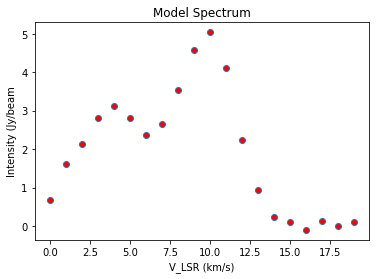

In [12]:
# create a model with 2 gaussians
# first, create an array of 2 1-d gaussian functionals
fn = functional()
g1d = [
    fn.gaussian1d(amplitude=5, center=10, fwhm=4),
    fn.gaussian1d(amplitude=3, center=4, fwhm=6)
  ]

# create x and y arrays to hold the x and y data for the model
x = []
y = []

npixels = 20

# create some gaussian noise to add to the y values
r = np.random.normal(0, 0.2, npixels)

ngauss = len(g1d)

# populate the x and y arrays with data
for i in range(20):
    x.append(i)
    res = 0
    for j in range(ngauss):
        res += g1d[j].f(i)
    y.append(res + r[i])

# plot the data
import matplotlib.pyplot as plt
def plot_it(x, y, yfit=None):
  plt.plot(x, y, linestyle='', marker='o', markerfacecolor='red')
  plt.xlabel('V_LSR (km/s)')
  plt.ylabel('Intensity (Jy/beam')
  plt.title('Model Spectrum')
  if yfit:
    plt.plot(x, yfit)
  plt.show()

plot_it(x, y)




Perform the fit of two 1-d gaussians to the data

In [13]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [6, 4, 9, 3, 2, 5]

# this line does the actual fit
popt, pcov = curve_fit(
      lambda x, *params_0:
        wrapper_fit_func(x, ngauss, params_0), x, y, p0=params_0
    )
# compute the estimated errors from the pcov diagonal
perr = np.sqrt(np.diag(pcov))

# print the fit solution
ndigits = 3
print('Solution for first gaussian:')
print('  Amplitude:', round(popt[0], ndigits), '+/-', round(perr[0], ndigits))
print('  Center:', round(popt[2], ndigits), '+/-', round(perr[2], ndigits))
print('  FWHM:', round(popt[4], ndigits), '+/-', round(perr[4], ndigits))
print()
print('Solution for second gaussian')
print('  Amplitude:', round(popt[1], ndigits), '+/-', round(perr[1], ndigits))
print('  Center:', round(popt[3], ndigits), '+/-', round(perr[3], ndigits))
print('  FWHM:', round(popt[5], ndigits), '+/-', round(perr[5], ndigits))



Solution for first gaussian:
  Amplitude: 4.939 +/- 0.081
  Center: 9.849 +/- 0.05
  FWHM: 4.084 +/- 0.105

Solution for second gaussian
  Amplitude: 3.037 +/- 0.066
  Center: 3.894 +/- 0.096
  FWHM: 5.602 +/- 0.252


Plot the fit

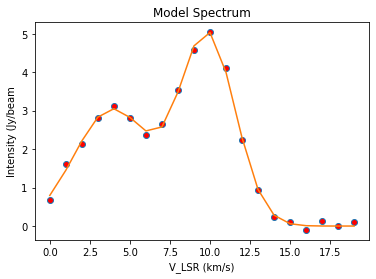

In [14]:
yfit = []
for i in range(npixels):
  res = 0
  for j in range(ngauss):
    res += gaussian1d(i, popt[j], popt[j + 2], popt[j + 4])
  yfit.append(res)

plot_it(x, y, yfit)

                      